# Análisis Exploratorio de Datos (EDA)

En este notebook cargaremos los datos de entrenamiento y generaremos **inline** todas las visualizaciones
del proyecto Steel Plate Defect Prediction, aprovechando las funciones de `src/visualization/eda.py`.

In [3]:
%matplotlib inline
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.autolayout": True})

from src.visualization.eda import load_data

df = load_data(
    "../data/raw/playground-series-s4e3/train.csv"
)
print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (19219, 35)


,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 4.1 Estadísticas Resumen y Balance de Clases

Primero calculamos estadísticos descriptivos y balance de cada una de las 7 clases de defecto.


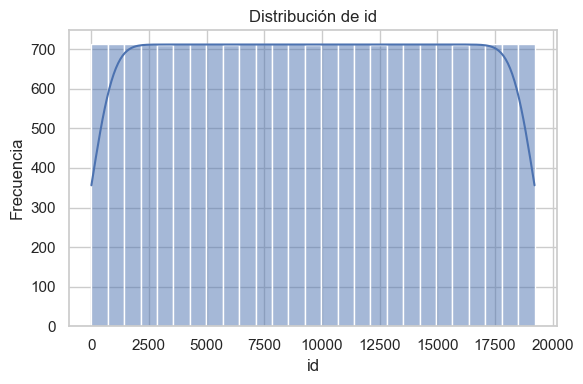

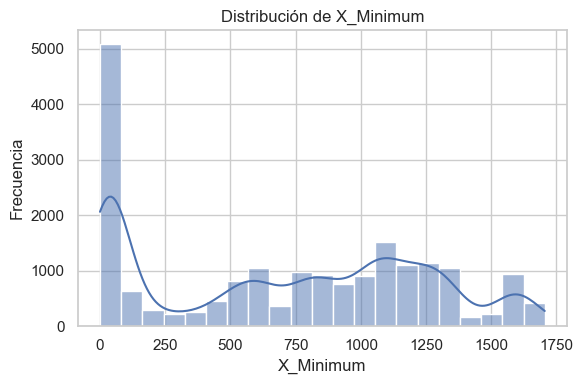

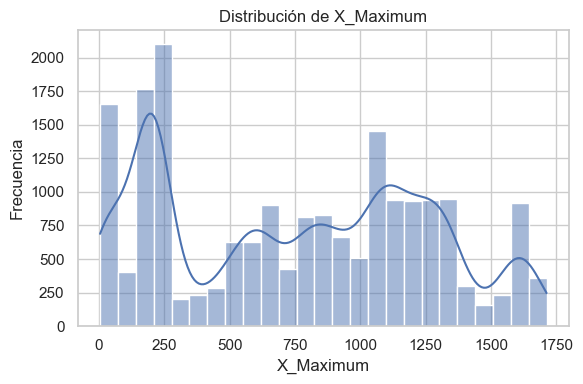

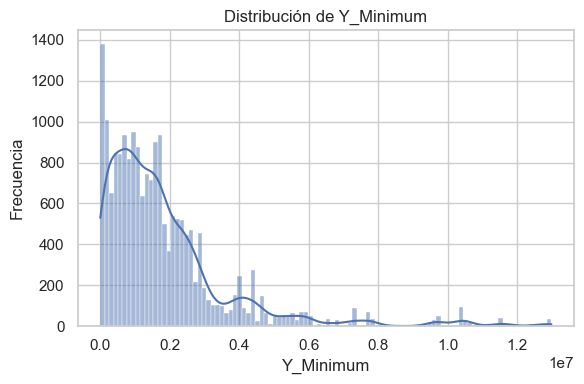

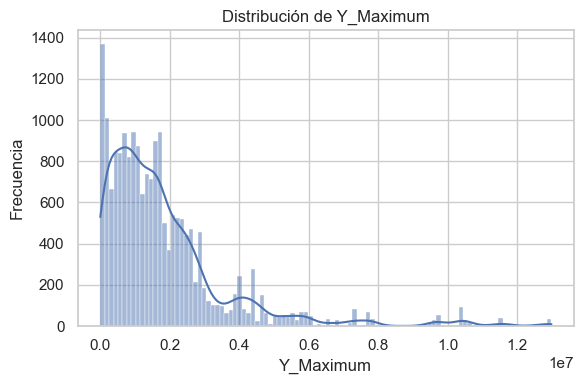

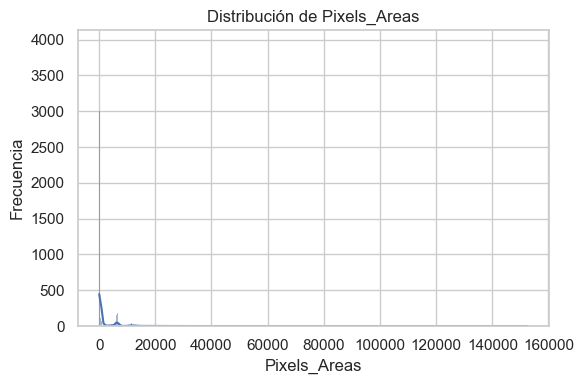

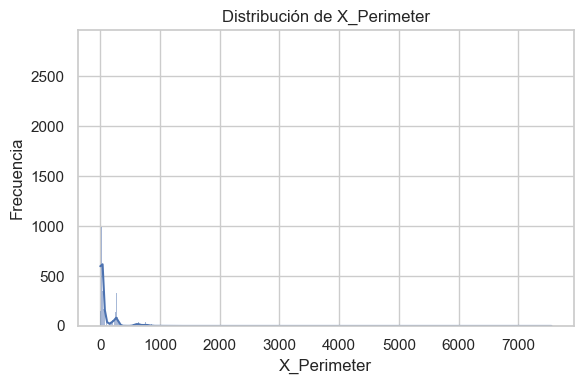

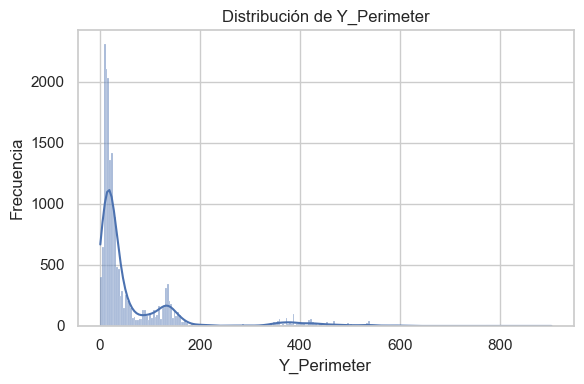

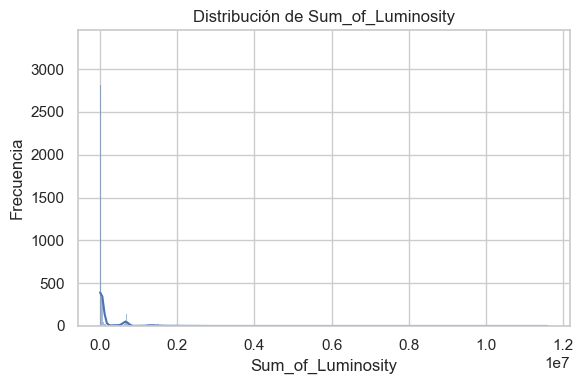

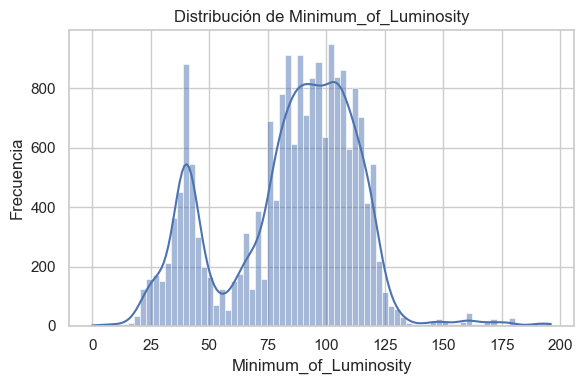

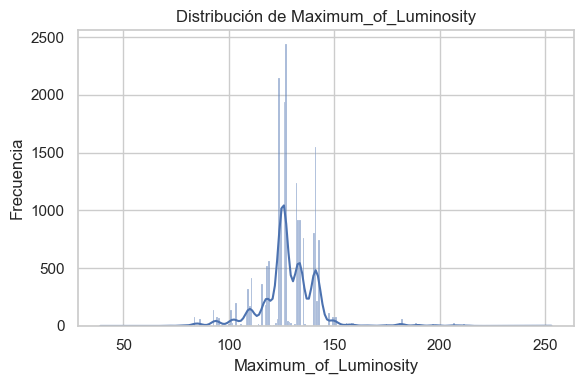

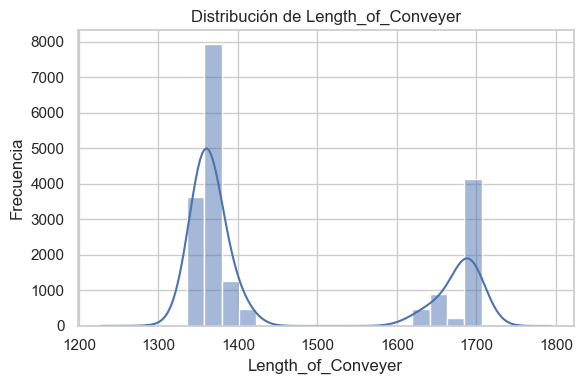

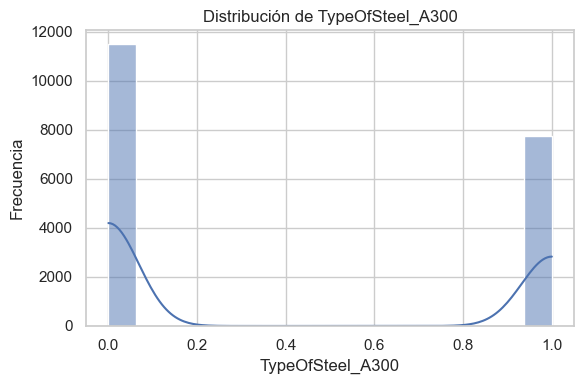

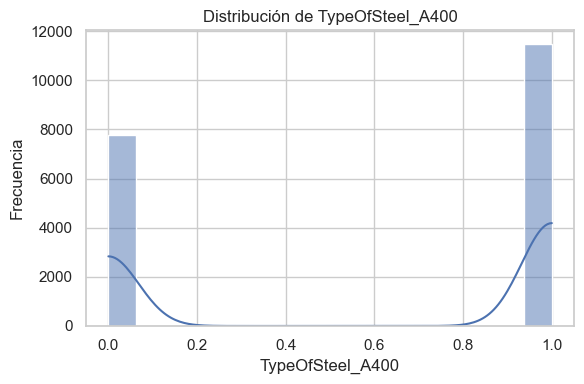

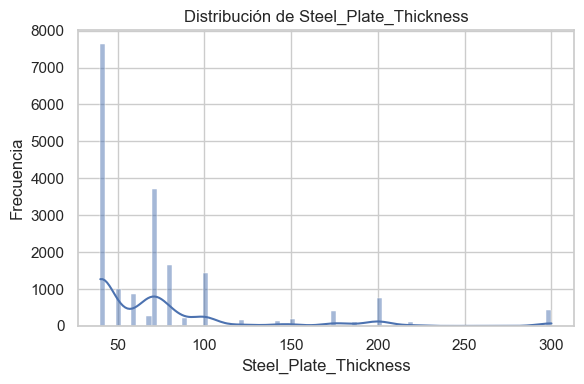

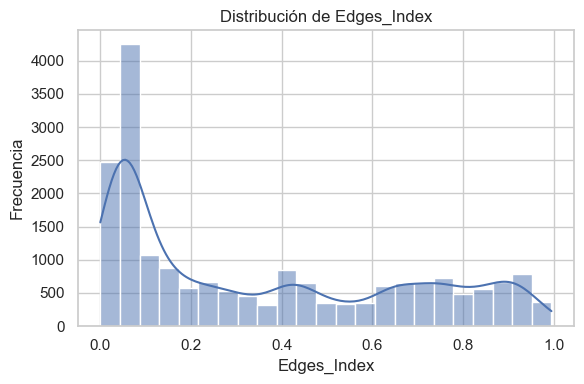

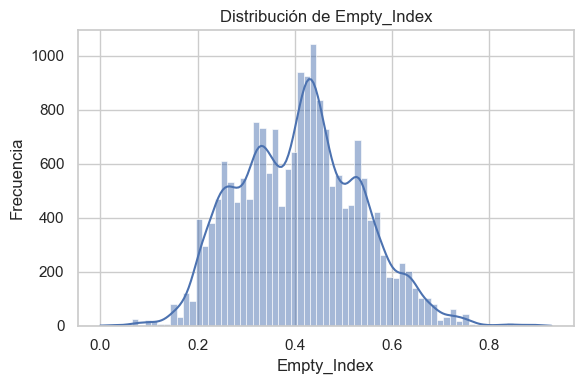

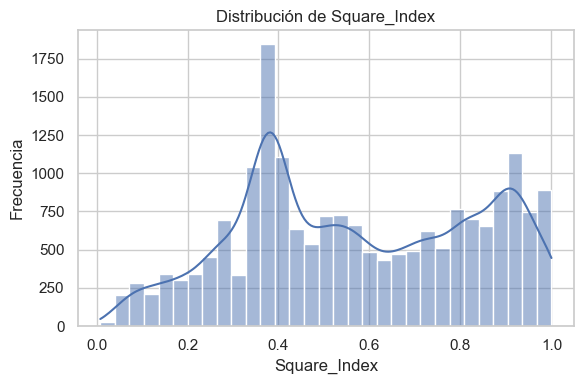

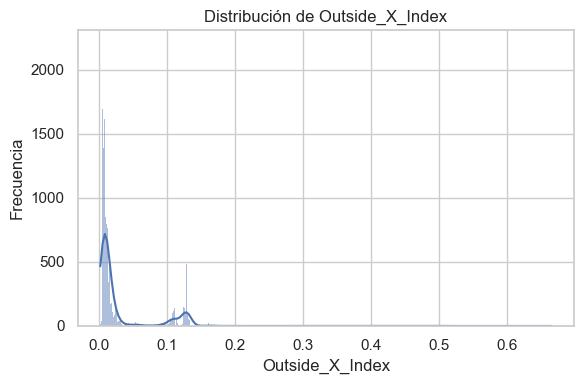

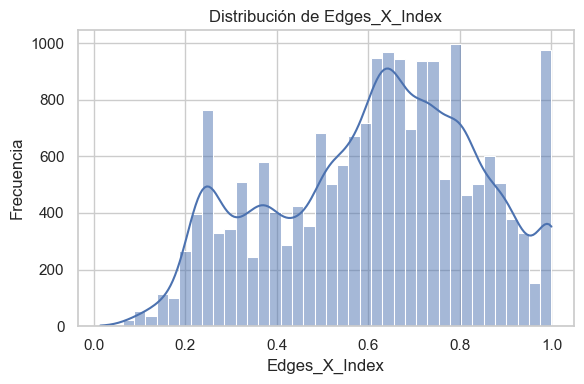

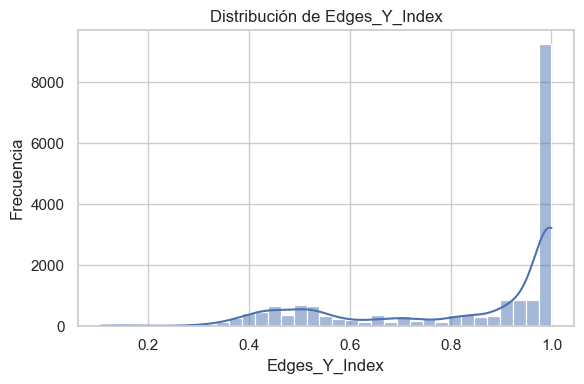

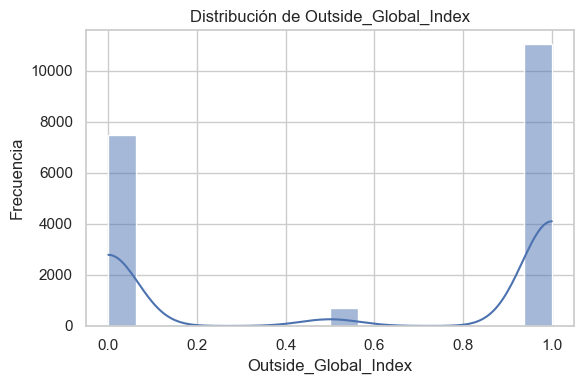

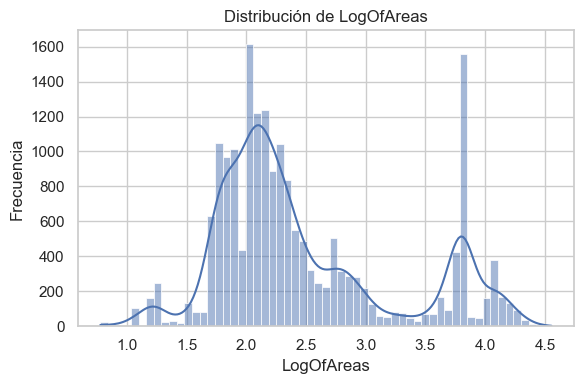

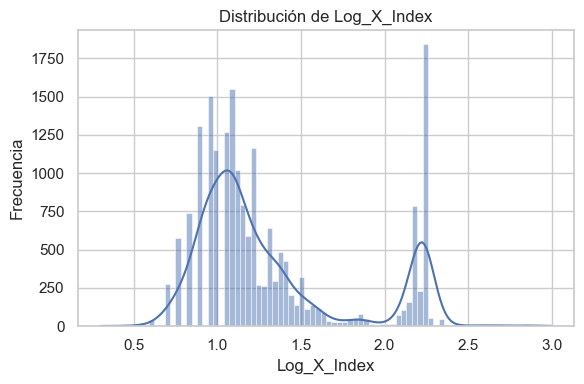

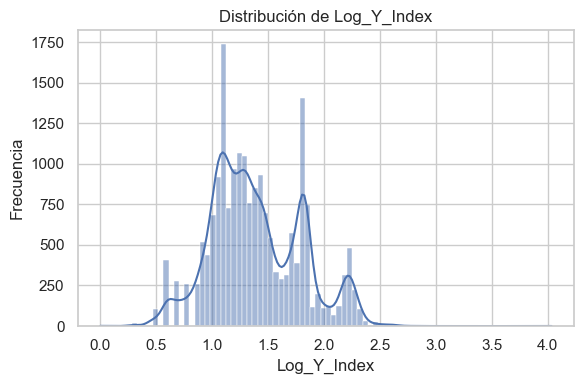

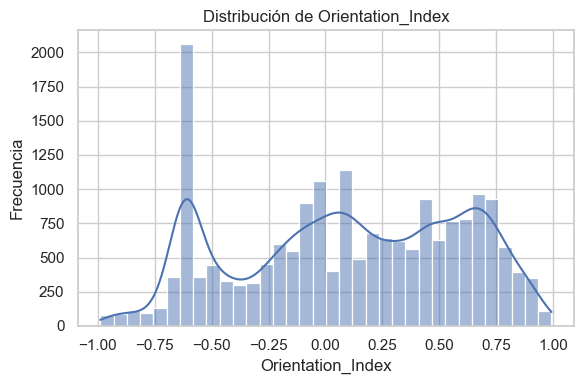

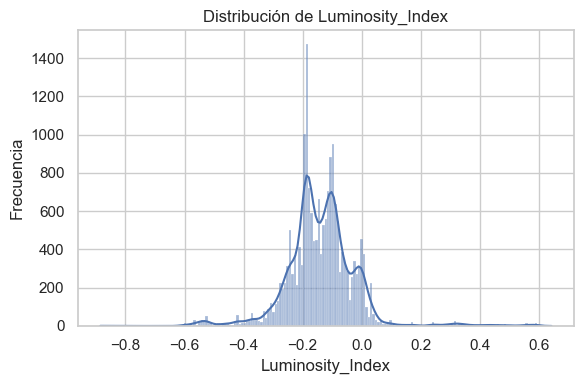

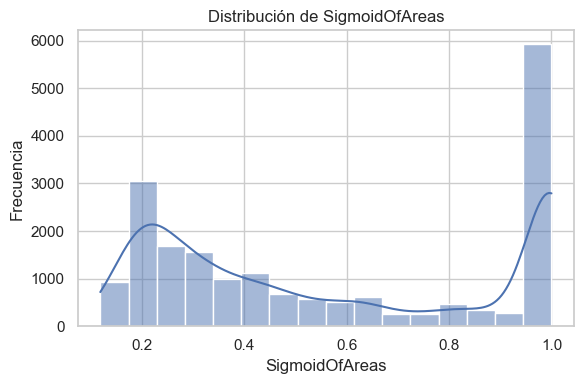

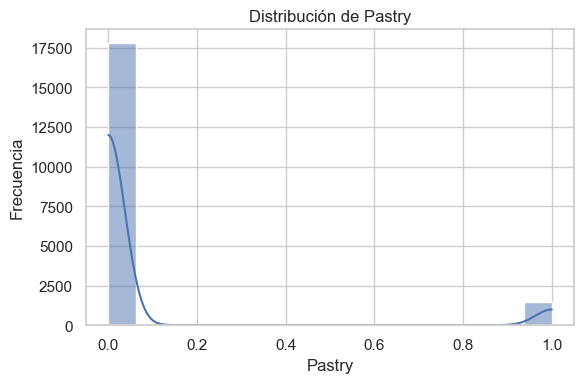

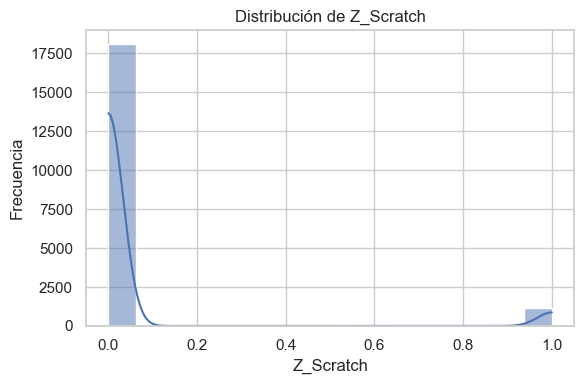

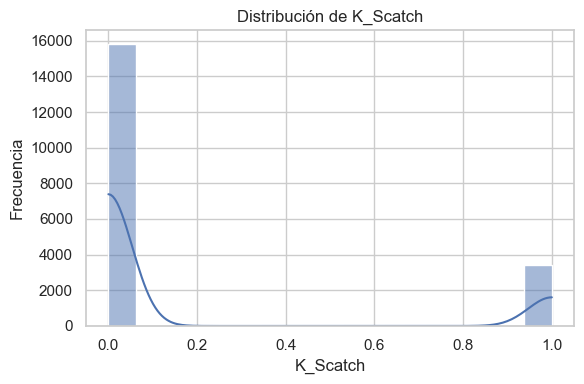

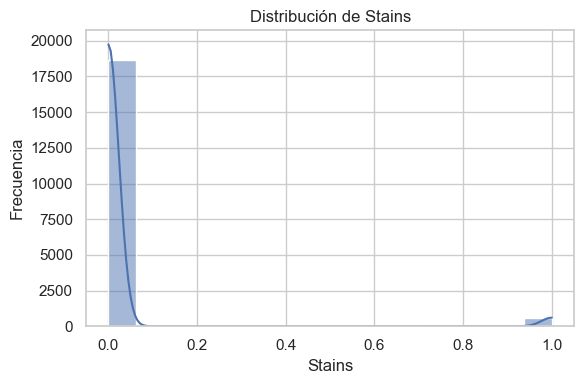

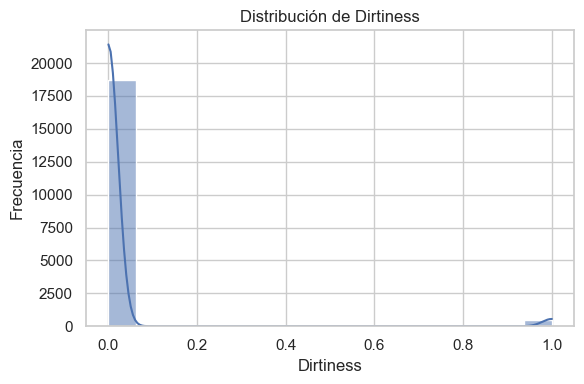

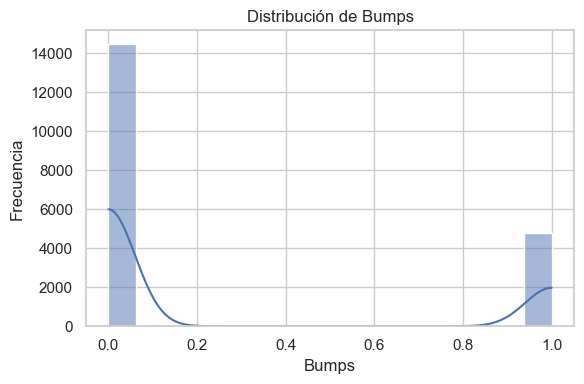

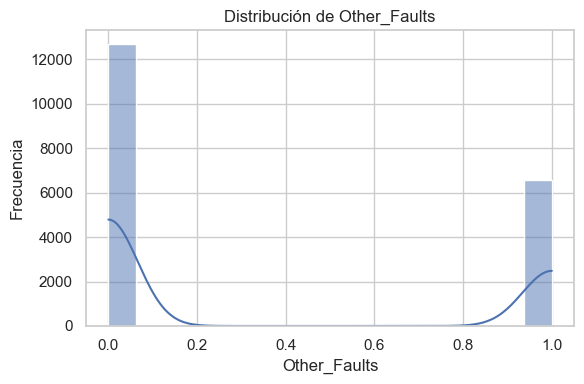

In [2]:
# Histogramas y KDE
for col in df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

In [ ]:
# Estadísticas descriptivas
numeric_stats = df.describe().T
numeric_stats["iqr"] = numeric_stats["75%"] - numeric_stats["25%"]
display(numeric_stats)

# Balance de clases
targets = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
balance = (
    df[targets].sum()
    .rename("positives")
    .to_frame()
)
balance["percent"] = balance["positives"] / len(df) * 100
display(balance)

In [17]:
# 1) Estadísticas básicas
numeric_stats = df.describe().T
numeric_stats["iqr"] = numeric_stats["75%"] - numeric_stats["25%"]
numeric_stats_features = numeric_stats.drop(index=targets)

# Balance de clases
targets = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
balance = (
    df[targets].sum()
    .rename("positives")
    .to_frame()
)
balance["percent"] = balance["positives"] / len(df) * 100
display(balance)

def highlight_high_std(row, factor=1):
    styles = [""] * len(row)
    if row["std"] > factor * row["mean"]:
        # pintamos sólo la posición de "std"
        idx = row.index.get_loc("std")
        styles[idx] = "background-color: #FFC7CE"
    return styles

def highlight_extremes(row):
    styles = [""] * len(row)
    q25 = row["25%"]
    q75 = row["75%"]
    iqr = q75 - q25
    if row["min"] < q25 - 1.5 * iqr:
        styles[row.index.get_loc("min")] = "background-color: #FFEB9C"
    if row["max"] > q75 + 1.5 * iqr:
        styles[row.index.get_loc("max")] = "background-color: #FFEB9C"
    return styles

# 4) Aplicación del estilo con Styler
styled = (
    numeric_stats_features
    .style
    .apply(highlight_high_std, axis=1)
    .apply(highlight_extremes, axis=1)
    .background_gradient(subset=["iqr"], cmap="Blues")
)

styled


,positives,percent
Pastry,1466.0,7.627868
Z_Scratch,1150.0,5.983662
K_Scatch,3432.0,17.857329
Stains,568.0,2.955409
Dirtiness,485.0,2.523544
Bumps,4763.0,24.782767
Other_Faults,6558.0,34.122483


,count,mean,std,min,25%,50%,75%,max,iqr
id,19219.000000,9609.000000,5548.191747,0.000000,4804.500000,9609.000000,14413.500000,19218.000000,9609.000000
X_Minimum,19219.000000,709.854675,531.544189,0.000000,49.000000,777.000000,1152.000000,1705.000000,1103.000000
X_Maximum,19219.000000,753.857641,499.836603,4.000000,214.000000,796.000000,1165.000000,1713.000000,951.000000
Y_Minimum,19219.000000,1849756.040012,1903553.850679,6712.000000,657468.000000,1398169.000000,2368032.000000,12987661.000000,1710564.000000
Y_Maximum,19219.000000,1846605.345439,1896295.137914,6724.000000,657502.000000,1398179.000000,2362511.000000,12987692.000000,1705009.000000
Pixels_Areas,19219.000000,1683.987616,3730.319865,6.000000,89.000000,168.000000,653.000000,152655.000000,564.000000
X_Perimeter,19219.000000,95.654665,177.821382,2.000000,15.000000,25.000000,64.000000,7553.000000,49.000000
Y_Perimeter,19219.000000,64.124096,101.054178,1.000000,14.000000,23.000000,61.000000,903.000000,47.000000
Sum_of_Luminosity,19219.000000,191846.678235,442024.694057,250.000000,9848.000000,18238.000000,67978.000000,11591414.000000,58130.000000
Minimum_of_Luminosity,19219.000000,84.808419,28.800344,0.000000,70.000000,90.000000,105.000000,196.000000,35.000000


## 4.2 Distribuciones

Visualizamos histogramas con KDE para cada variable numérica.

## 4.2.2 Boxplots por Defecto

Comparamos la distribución de cada feature para placas con y sin cada tipo de defecto.

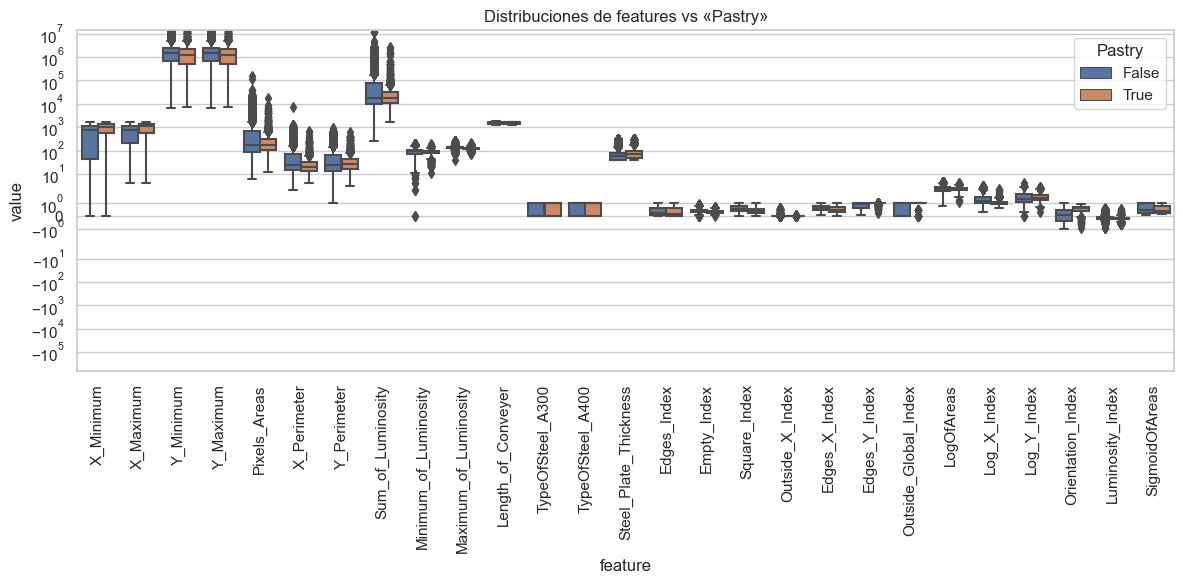

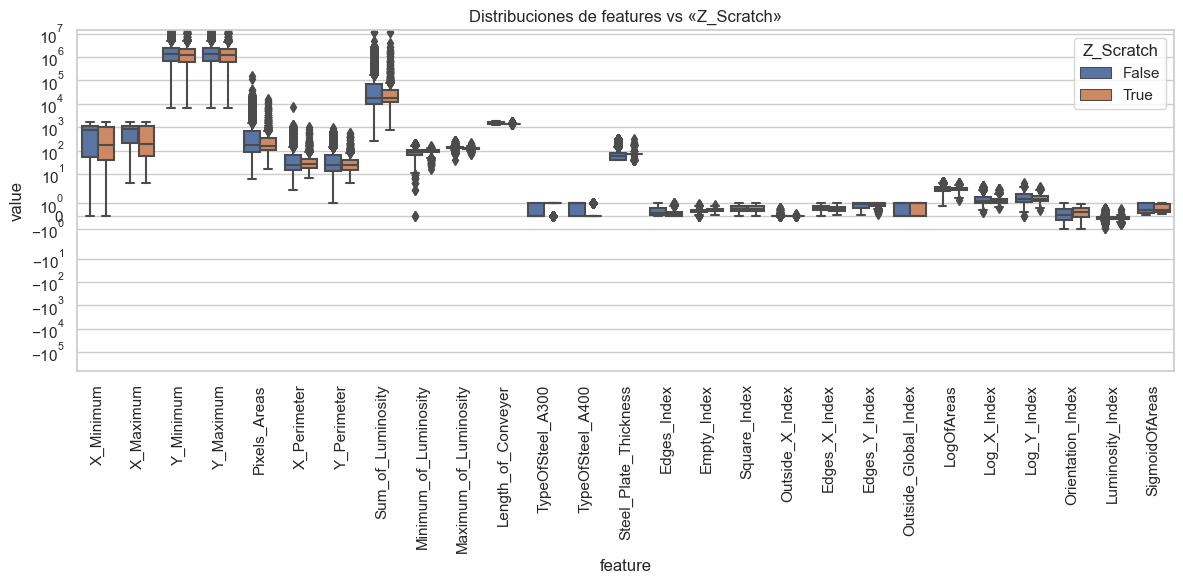

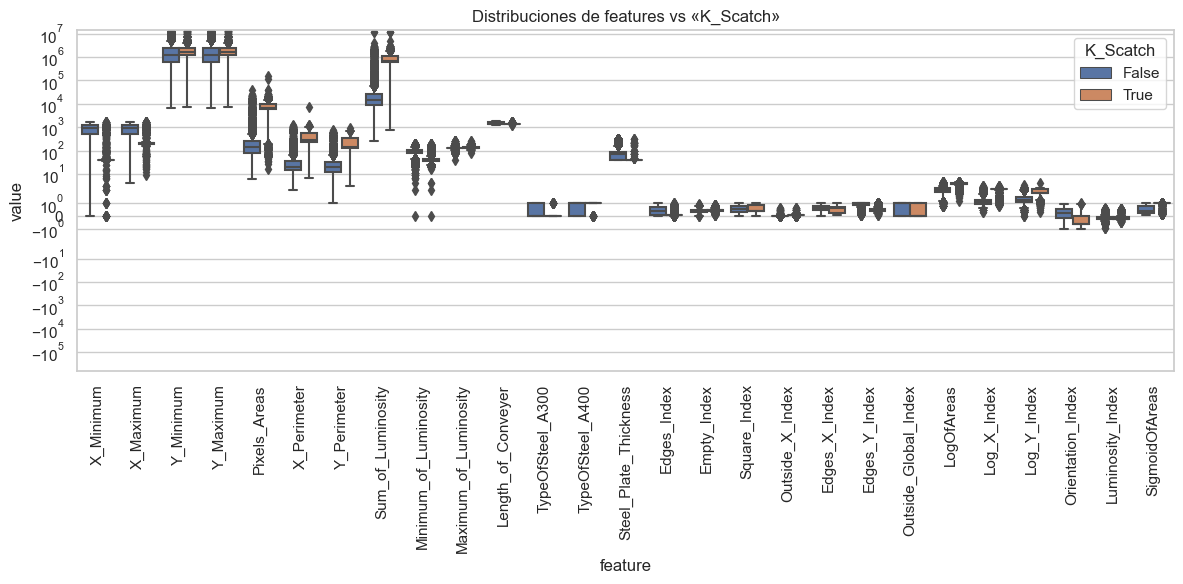

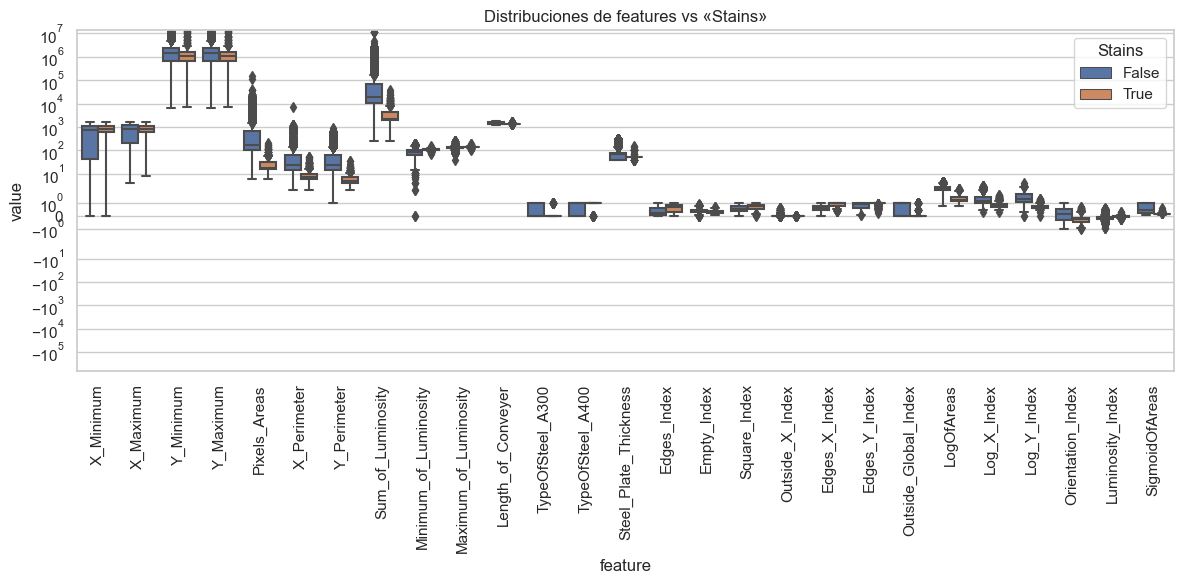

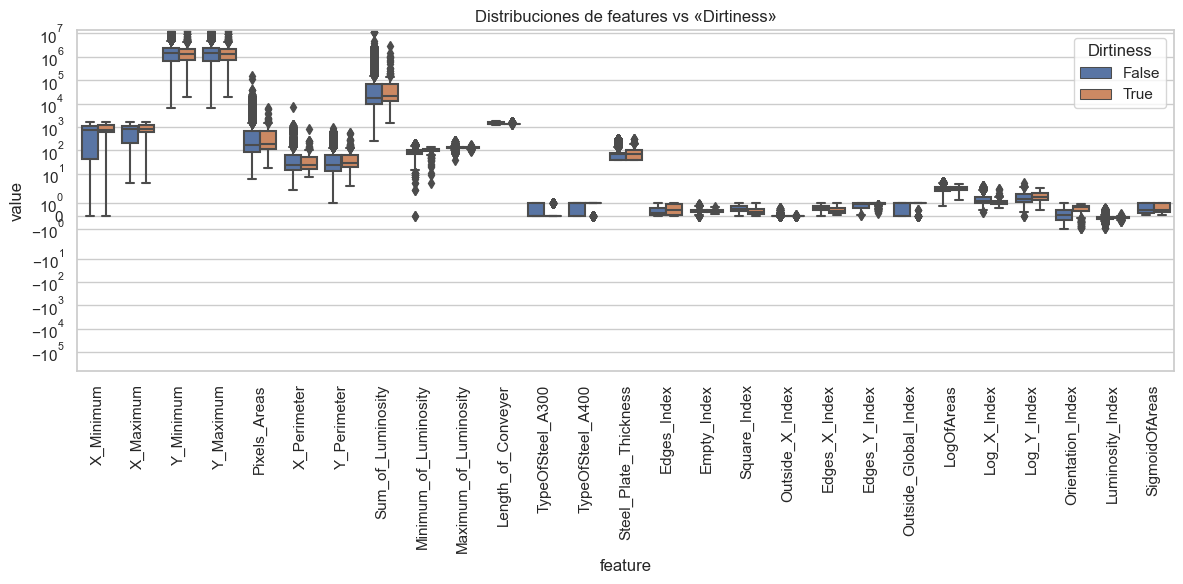

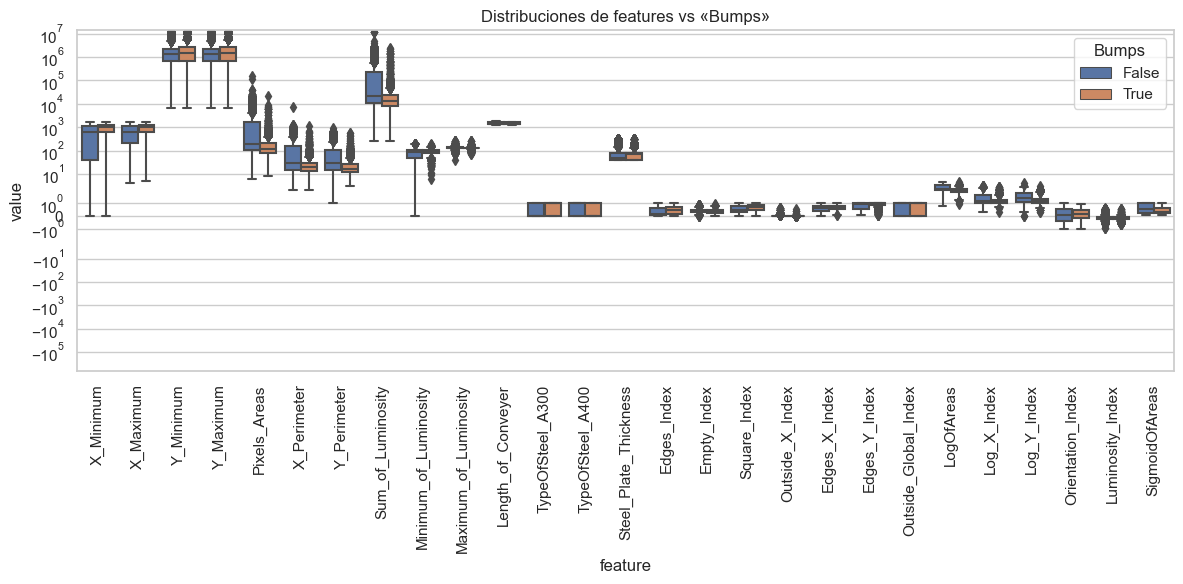

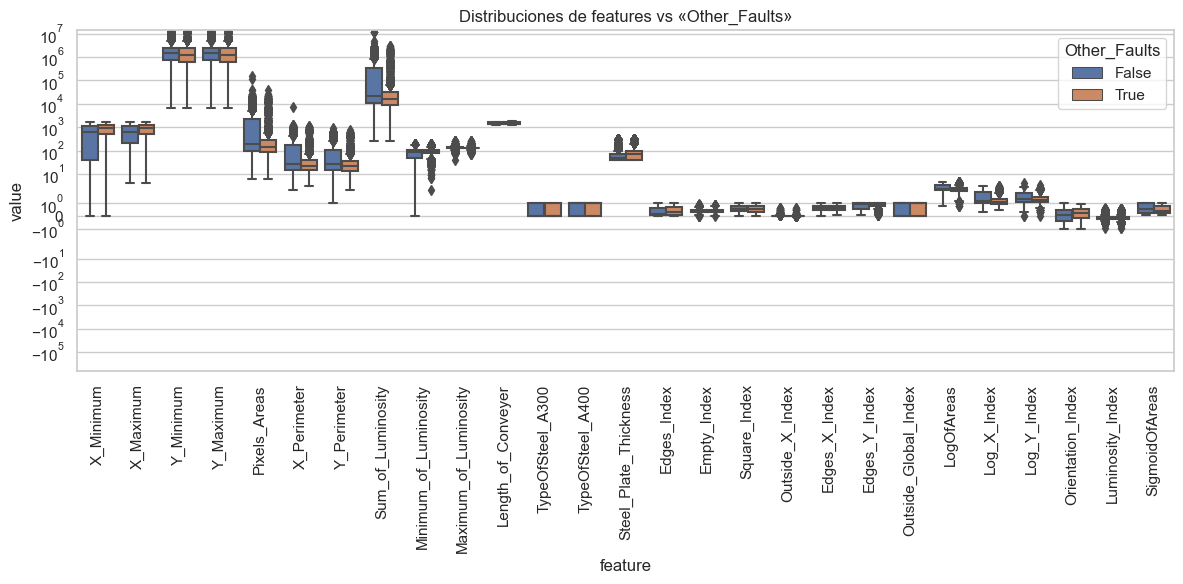

In [7]:
# Boxplots (log-scale opcional)
feature_cols = [c for c in df.columns if c not in targets + ["id"]]
for target in targets:
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=df.melt(id_vars=[target], value_vars=feature_cols, 
                     var_name="feature", value_name="value")
           .assign(**{target: lambda x: x[target].astype(bool)}),
        x="feature", y="value", hue=target
    )
    plt.yscale("symlog")  # escala simétrica logarítmica para manejar ceros/negativos
    plt.xticks(rotation=90)
    plt.title(f"Distribuciones de features vs «{target}»")
    plt.tight_layout()
    plt.show()

## 4.2.3 Mapa de Calor de Correlaciones

Matriz de correlación Pearson entre todas las variables numéricas.

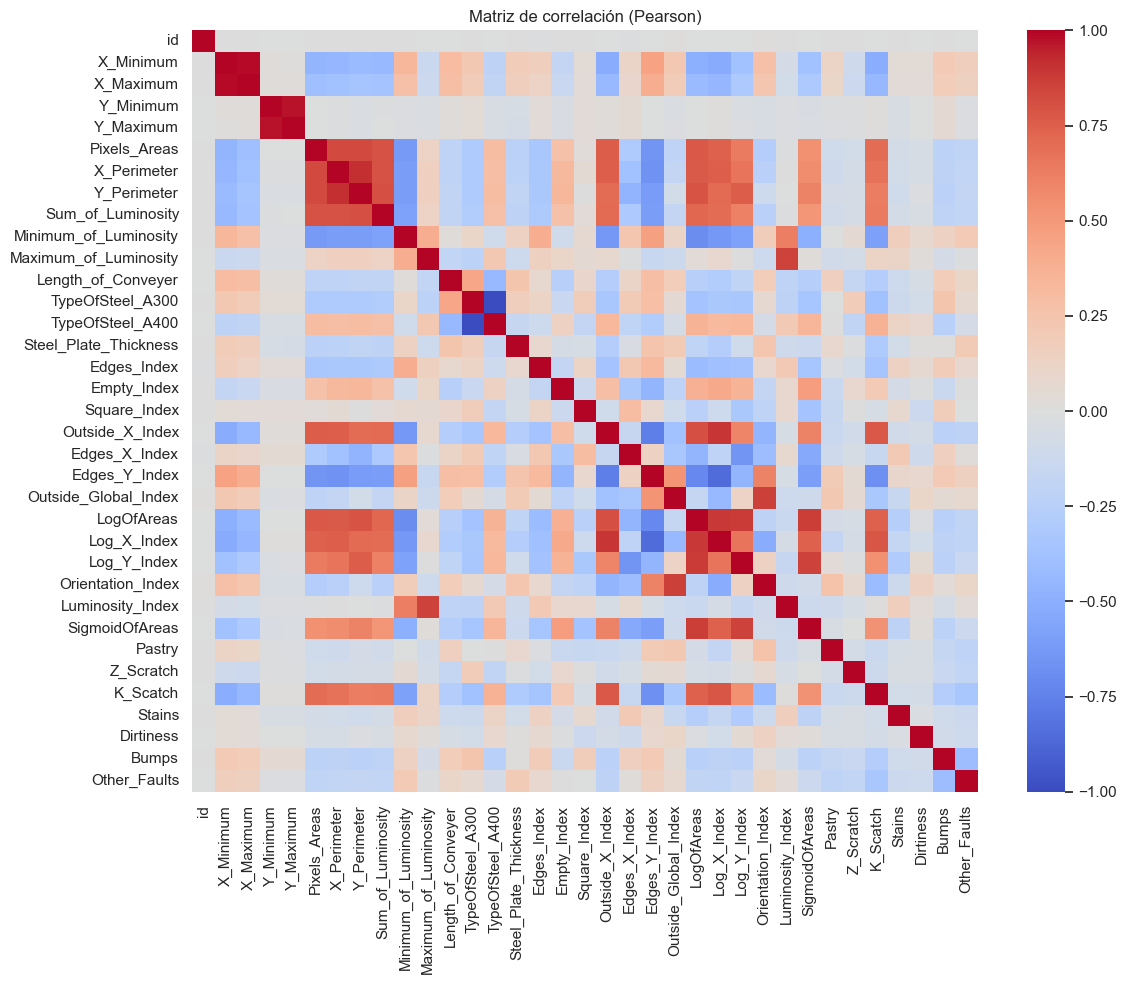

In [5]:
plt.figure(figsize=(12,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=1, vmin=-1)
plt.title("Matriz de correlación (Pearson)")
plt.show()

## 4.3 Valores Faltantes

Mostramos tabla y heatmap de missing values.

,n_missing,percent
id,0,0.0
X_Minimum,0,0.0
X_Maximum,0,0.0
Y_Minimum,0,0.0
Y_Maximum,0,0.0
Pixels_Areas,0,0.0
X_Perimeter,0,0.0
Y_Perimeter,0,0.0
Sum_of_Luminosity,0,0.0
Minimum_of_Luminosity,0,0.0


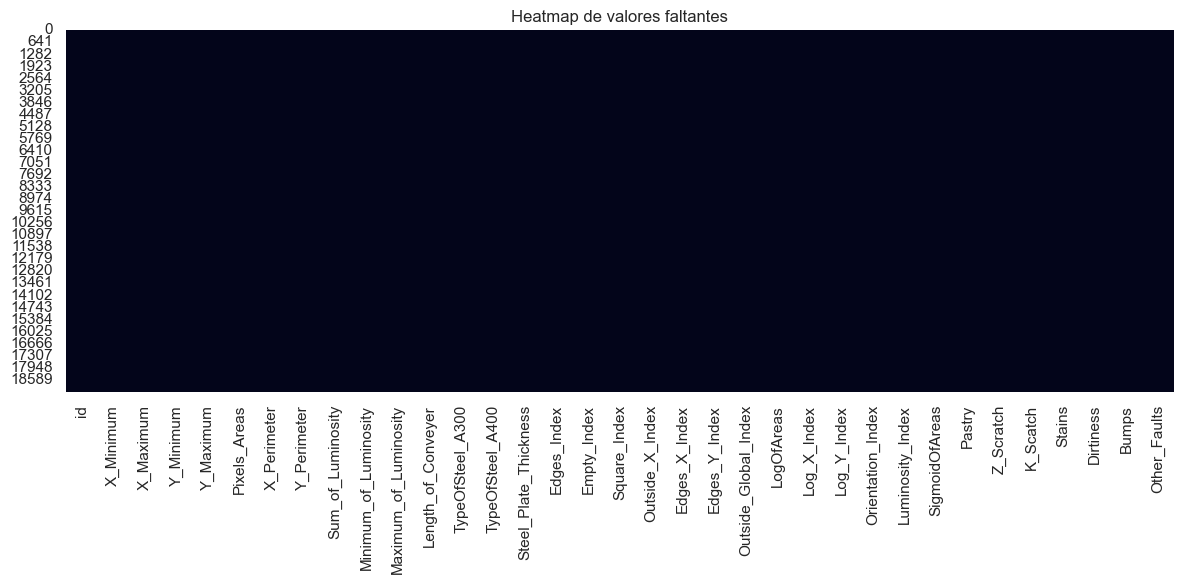

In [19]:
# Tabla de valores faltantes
missing = df.isna().sum().rename("n_missing").to_frame()
missing["percent"] = missing["n_missing"] / len(df) * 100
display(missing)

# Heatmap de missing
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Heatmap de valores faltantes")
plt.show()

## 4.4 Detección de Outliers (IQR)

Contamos outliers por la regla 1.5 × IQR.

In [10]:
# Detección de outliers
outlier_counts = {}
for col in df.select_dtypes(include=np.number).columns:
    q1, q3 = np.percentile(df[col].dropna(), [25,75])
    iqr = q3 - q1
    mask = (df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)
    outlier_counts[col] = mask.sum()

outliers_df = pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["n_outliers"])
display(outliers_df)

,n_outliers
id,0
X_Minimum,0
X_Maximum,0
Y_Minimum,1118
Y_Maximum,1112
Pixels_Areas,3722
X_Perimeter,3717
Y_Perimeter,2785
Sum_of_Luminosity,3826
Minimum_of_Luminosity,211


In [33]:
x = df.drop(columns=targets)
p95 = df["Pixels_Areas"].quantile(0.95)

IMG_WIDTH = 1700
IMG_HEIGHT = 12_800_000

x["Width"]               = x["X_Maximum"] - x["X_Minimum"]
x["Height"]              = x["Y_Maximum"] - x["Y_Minimum"]
x["Aspect_Ratio"]        = x["Width"] / (x["Height"] + 1e-6)
x["X_Center_norm"]       = (x["X_Minimum"] + x["X_Maximum"]) / 2 / IMG_WIDTH
x["Y_Center_norm"]       = (x["Y_Minimum"] + x["Y_Maximum"]) / 2 / IMG_HEIGHT
x["Mean_Luminosity"]     = x["Sum_of_Luminosity"] / (x["Pixels_Areas"] + 1e-6)
x["Max_to_Mean_Luminosity"] = x["Maximum_of_Luminosity"] / (x["Mean_Luminosity"] + 1e-6)
x["is_very_large"]       = (x["Pixels_Areas"] > p95).astype(int)

# Inspección rápida
display(x[[
    "Width","Height","Aspect_Ratio",
    "X_Center_norm","Y_Center_norm",
    "Mean_Luminosity","Max_to_Mean_Luminosity",
    "is_very_large"
]].describe().T)

print((x["Height"] < 0).sum())

# Échales un ojo
x.loc[x["Height"] < 0, ["Y_Minimum","Y_Maximum","Height"]].head()


,count,mean,std,min,25%,50%,75%,max
Width,19219.0,44.002966,8.026666e+01,-1.128000e+03,10.000000,14.000000,27.000000,1.665000e+03
Height,19219.0,-3150.694573,4.688983e+05,-1.231342e+07,11.000000,20.000000,53.000000,1.162441e+07
Aspect_Ratio,19219.0,393050.069156,6.945362e+06,-6.950007e+02,0.377778,0.800000,1.500000,2.260000e+08
X_Center_norm,19219.0,0.430504,3.025710e-01,1.176471e-03,0.075588,0.460882,0.681471,1.005294e+00
Y_Center_norm,19219.0,0.144389,1.472974e-01,5.248438e-04,0.051808,0.109266,0.184876,1.014662e+00
Mean_Luminosity,19219.0,132.783266,3.267160e+02,1.088474e-01,102.166666,109.652173,118.436503,1.268227e+04
Max_to_Mean_Luminosity,19219.0,1.517018,1.370661e+01,1.031503e-02,1.093671,1.170492,1.235418,1.139199e+03
is_very_large,19219.0,0.050003,2.179560e-01,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00


690


,Y_Minimum,Y_Maximum,Height
11,2421293,2421292,-1
28,463001,462989,-12
32,1859633,1859616,-17
47,1377782,1377748,-34
59,1700639,1700480,-159


,skew
Max_to_Mean_Luminosity,74.19
Mean_Luminosity,29.16
Aspect_Ratio,23.05
Pixels_Areas,6.98
Sum_of_Luminosity,6.69
X_Perimeter,6.32
is_very_large,4.13
Width,3.96
Outside_X_Index,3.12
Y_Perimeter,2.98


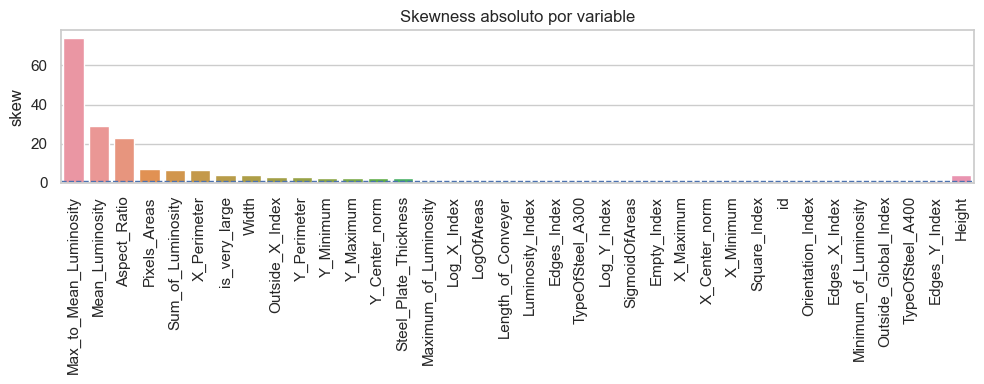

In [29]:


skew_vals = (
    x.select_dtypes(include="number")
      .skew()                               # skewness de Pearson
      .sort_values(ascending=False)
      .to_frame("skew")
)

display(skew_vals.style.format("{:.2f}")
                    .background_gradient(cmap="coolwarm", vmin=-2, vmax=2))

# Visual rápido: barras de skewness absolutas
plt.figure(figsize=(10, 4))
sns.barplot(x=skew_vals.index,
            y=skew_vals["skew"].abs())
plt.axhline(1, ls="--", lw=1)               # regla de oro |skew|>1
plt.title("Skewness absoluto por variable")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()